In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("军事通信效能评估系统 - 组合赋权法")
print("="*80)
print(f"评估时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

军事通信效能评估系统 - 组合赋权法
评估时间: 2026-02-10 18:30:49



In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'military_communication_effectiveness',
    'charset': 'utf8mb4'
}

def get_db_connection():
    """获取数据库连接"""
    return mysql.connector.connect(**DB_CONFIG)

def extract_indicators_from_raw_tables():
    """
    从原始表中提取20个指标
    整合 during_battle_communications 和 communication_network_lifecycle 表的数据
    
    返回:
        DataFrame: 包含20个指标的数据框
    """
    conn = get_db_connection()
    
    # SQL查询1: 从 during_battle_communications 表聚合数据
    query_dbc = """
    SELECT 
        test_id,
        scenario_id,
        
        -- C1. 响应能力 (RS)
        AVG(call_setup_duration_ms) as RS_avg_call_setup_duration_ms,
        AVG(transmission_delay_ms) as RS_avg_transmission_delay_ms,
        
        -- C2. 处理能力 (PO)
        AVG(instant_throughput) as PO_effective_throughput,
        AVG(instant_throughput / channel_bandwidth) as PO_spectral_efficiency,
        
        -- C3. 有效性 (EF)
        AVG(communication_distance) as EF_avg_communication_distance,
        AVG(instant_ber) as EF_avg_ber,
        AVG(instant_plr) as EF_avg_plr,
        SUM(CASE WHEN communication_success = 1 THEN 1 ELSE 0 END) / COUNT(*) as EF_task_success_rate,
        
        -- C4. 可靠性 (RL) - 部分指标
        SUM(CASE WHEN communication_success = 1 THEN 1 ELSE 0 END) / COUNT(*) as RL_communication_success_rate,
        
        -- C5. 抗干扰性 (AJ)
        AVG(instant_sinr) as AJ_avg_sinr,
        AVG(jamming_margin) as AJ_avg_jamming_margin,
        
        -- C6. 人为操作 (HO)
        AVG(operator_reaction_time_ms) as HO_avg_operator_reaction_time_ms,
        SUM(CASE WHEN operation_error = 0 THEN 1 ELSE 0 END) / COUNT(*) as HO_operation_success_rate,
        
        -- C8. 安全性 (SC)
        SUM(CASE WHEN key_updated = 1 THEN 1 ELSE 0 END) / 
            NULLIF(SUM(communication_duration_ms) / 3600000.0, 0) as SC_key_compromise_frequency,
        SUM(CASE WHEN detected = 1 THEN 1 ELSE 0 END) / COUNT(*) as SC_detection_probability,
        1 - (SUM(CASE WHEN intercepted = 1 THEN 1 ELSE 0 END) / 
            NULLIF(COUNT(*), 0)) as SC_interception_resistance,
        
        -- 统计信息
        COUNT(*) as total_communications
        
    FROM during_battle_communications
    GROUP BY test_id, scenario_id
    ORDER BY test_id
    """
    
    # SQL查询2: 从 communication_network_lifecycle 表聚合数据
    query_lc = """
    SELECT 
        test_id,
        scenario_id,
        
        -- C4. 可靠性 (RL) - 剩余指标
        (SUM(total_lifecycle_duration_ms) - COALESCE(SUM(total_interruption_duration_ms), 0)) / 
            NULLIF(SUM(total_lifecycle_duration_ms), 0) as RL_communication_availability_rate,
        AVG(CASE WHEN network_crash_occurred = 1 THEN total_interruption_duration_ms ELSE NULL END) as RL_recovery_duration_ms,
        SUM(CASE WHEN network_crash_occurred = 1 THEN 1 ELSE 0 END) / COUNT(*) as RL_crash_rate,
        
        -- C7. 组网能力 (NC)
        AVG(network_setup_duration_ms) as NC_avg_network_setup_duration_ms,
        AVG(connectivity_rate) as NC_avg_connectivity_rate,
        
        -- 统计信息
        COUNT(*) as total_lifecycles
        
    FROM communication_network_lifecycle
    GROUP BY test_id, scenario_id
    ORDER BY test_id
    """
    
    # 执行查询
    df_dbc = pd.read_sql(query_dbc, conn)
    df_lc = pd.read_sql(query_lc, conn)
    conn.close()
    
    # 合并两个数据框
    df_merged = pd.merge(df_dbc, df_lc, on=['test_id', 'scenario_id'], how='left')
    
    # 处理缺失值
    df_merged['RL_communication_availability_rate'] = df_merged['RL_communication_availability_rate'].fillna(1.0)
    df_merged['RL_recovery_duration_ms'] = df_merged['RL_recovery_duration_ms'].fillna(0)
    df_merged['RL_crash_rate'] = df_merged['RL_crash_rate'].fillna(0)
    df_merged['NC_avg_connectivity_rate'] = df_merged['NC_avg_connectivity_rate'] / 100.0  # 转换为0-1
    
    return df_merged

print("步骤1: 从原始表提取20个评估指标")
print("-"*80)

# 从原始表提取数据
df_raw = extract_indicators_from_raw_tables()

print(f"✓ 成功从 during_battle_communications 表提取数据")
print(f"✓ 成功从 communication_network_lifecycle 表提取数据")
print(f"✓ 合并后共 {len(df_raw)} 个测试批次")
print(f"✓ 包含 21 个评估指标")
print()

# 显示提取的数据预览
print("提取的数据预览:")
preview_cols = ['test_id', 'RS_avg_call_setup_duration_ms', 'PO_effective_throughput', 
                'RL_crash_rate', 'SC_detection_probability', 'total_communications']
print(df_raw[preview_cols].to_string(index=False))
print()

步骤1: 从原始表提取20个评估指标
--------------------------------------------------------------------------------
✓ 成功从 during_battle_communications 表提取数据
✓ 成功从 communication_network_lifecycle 表提取数据
✓ 合并后共 10 个测试批次
✓ 包含 21 个评估指标

提取的数据预览:
      test_id  RS_avg_call_setup_duration_ms  PO_effective_throughput  RL_crash_rate  SC_detection_probability  total_communications
TEST-2026-001                    1521.608846             31294.087308         0.0000                    0.0385                    26
TEST-2026-002                    1447.931115             25623.263077         0.0000                    0.0000                    26
TEST-2026-003                    1381.833905             26080.912857         0.6667                    0.0000                    21
TEST-2026-004                    1517.714550             27383.045000         0.0000                    0.2000                    20
TEST-2026-005                    1531.415320             25776.820800         0.0000                    0.0400

In [3]:
print("存储评估数据到数据库")
print("-"*80)

def save_to_database(df_raw):
    """
    将原始指标数据和评估结果存储到 military_effectiveness_evaluation 表
    
    参数:
        df_raw: 原始指标数据
    """
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # 准备插入数据
    insert_count = 0
    update_count = 0
    
    for idx, row in df_raw.iterrows():
        test_id = row['test_id']
        scenario_id = row['scenario_id']
        
        # 检查是否已存在
        cursor.execute("SELECT evaluation_id FROM military_effectiveness_evaluation WHERE test_id = %s", (test_id,))
        existing = cursor.fetchone()
        
        if existing:
            # 更新现有记录
            update_sql = """
            UPDATE military_effectiveness_evaluation SET
                scenario_id = %s,
                RS_avg_call_setup_duration_ms = %s,
                RS_avg_transmission_delay_ms = %s,
                PO_effective_throughput = %s,
                PO_spectral_efficiency = %s,
                EF_avg_communication_distance = %s,
                EF_avg_ber = %s,
                EF_avg_plr = %s,
                EF_task_success_rate = %s,
                RL_communication_availability_rate = %s,
                RL_communication_success_rate = %s,
                RL_recovery_duration_ms = %s,
                RL_crash_rate = %s,
                AJ_avg_sinr = %s,
                AJ_avg_jamming_margin = %s,
                HO_avg_operator_reaction_time_ms = %s,
                HO_operation_success_rate = %s,
                NC_avg_network_setup_duration_ms = %s,
                NC_avg_connectivity_rate = %s,
                SC_key_compromise_frequency = %s,
                SC_detection_probability = %s,
                SC_interception_resistance = %s,
                total_communications = %s,
                total_lifecycles = %s,
                updated_at = CURRENT_TIMESTAMP
            WHERE test_id = %s
            """
            
            cursor.execute(update_sql, (
                scenario_id,
                row['RS_avg_call_setup_duration_ms'],
                row['RS_avg_transmission_delay_ms'],
                row['PO_effective_throughput'],
                row['PO_spectral_efficiency'],
                row['EF_avg_communication_distance'],
                row['EF_avg_ber'],
                row['EF_avg_plr'],
                row['EF_task_success_rate'],
                row['RL_communication_availability_rate'],
                row['RL_communication_success_rate'],
                row['RL_recovery_duration_ms'],
                row['RL_crash_rate'],
                row['AJ_avg_sinr'],
                row['AJ_avg_jamming_margin'],
                row['HO_avg_operator_reaction_time_ms'],
                row['HO_operation_success_rate'],
                row['NC_avg_network_setup_duration_ms'],
                row['NC_avg_connectivity_rate'],
                row['SC_key_compromise_frequency'],
                row['SC_detection_probability'],
                row['SC_interception_resistance'],
                row['total_communications'],
                row['total_lifecycles'],
                test_id
            ))
            update_count += 1
        else:
            # 插入新记录
            insert_sql = """
            INSERT INTO military_effectiveness_evaluation (
                scenario_id, test_id,
                RS_avg_call_setup_duration_ms, RS_avg_transmission_delay_ms,
                PO_effective_throughput, PO_spectral_efficiency,
                EF_avg_communication_distance, EF_avg_ber, EF_avg_plr, EF_task_success_rate,
                RL_communication_availability_rate, RL_communication_success_rate,
                RL_recovery_duration_ms, RL_crash_rate,
                AJ_avg_sinr, AJ_avg_jamming_margin,
                HO_avg_operator_reaction_time_ms, HO_operation_success_rate,
                NC_avg_network_setup_duration_ms, NC_avg_connectivity_rate,
                SC_key_compromise_frequency, SC_detection_probability, SC_interception_resistance,
                total_communications, total_lifecycles
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s
            )
            """
            
            cursor.execute(insert_sql, (
                scenario_id, test_id,
                row['RS_avg_call_setup_duration_ms'],
                row['RS_avg_transmission_delay_ms'],
                row['PO_effective_throughput'],
                row['PO_spectral_efficiency'],
                row['EF_avg_communication_distance'],
                row['EF_avg_ber'],
                row['EF_avg_plr'],
                row['EF_task_success_rate'],
                row['RL_communication_availability_rate'],
                row['RL_communication_success_rate'],
                row['RL_recovery_duration_ms'],
                row['RL_crash_rate'],
                row['AJ_avg_sinr'],
                row['AJ_avg_jamming_margin'],
                row['HO_avg_operator_reaction_time_ms'],
                row['HO_operation_success_rate'],
                row['NC_avg_network_setup_duration_ms'],
                row['NC_avg_connectivity_rate'],
                row['SC_key_compromise_frequency'],
                row['SC_detection_probability'],
                row['SC_interception_resistance'],
                row['total_communications'],
                row['total_lifecycles']
            ))
            insert_count += 1
    
    conn.commit()
    cursor.close()
    conn.close()
    
    return insert_count, update_count

try:
    insert_count, update_count = save_to_database(df_raw)
    print(f"✓ 数据存储成功")
    print(f"  - 新增记录: {insert_count} 条")
    print(f"  - 更新记录: {update_count} 条")
    print(f"  - 总计: {insert_count + update_count} 条")
except Exception as e:
    print(f"✗ 数据存储失败: {str(e)}")

存储评估数据到数据库
--------------------------------------------------------------------------------
✓ 数据存储成功
  - 新增记录: 0 条
  - 更新记录: 10 条
  - 总计: 10 条


In [4]:
print("步骤2: 定义指标体系")
print("-"*80)

# 指标配置：维度 → 指标列表
INDICATOR_SYSTEM = {
    'RL': {  # 可靠性 - 优先级1
        'name': '可靠性',
        'priority': 1,
        'indicators': [
            {'code': 'RL_communication_availability_rate', 'name': '通信可用性', 'direction': 'max'},
            {'code': 'RL_communication_success_rate', 'name': '通信成功率', 'direction': 'max'},
            {'code': 'RL_recovery_duration_ms', 'name': '恢复时长', 'direction': 'min'},
            {'code': 'RL_crash_rate', 'name': '崩溃比例', 'direction': 'min'}
        ]
    },
    'SC': {  # 安全性 - 优先级2
        'name': '安全性',
        'priority': 2,
        'indicators': [
            {'code': 'SC_key_compromise_frequency', 'name': '密钥泄露频率', 'direction': 'min'},
            {'code': 'SC_detection_probability', 'name': '被侦察概率', 'direction': 'min'},
            {'code': 'SC_interception_resistance', 'name': '抗拦截能力', 'direction': 'max'}
        ]
    },
    'AJ': {  # 抗干扰性 - 优先级3
        'name': '抗干扰性',
        'priority': 3,
        'indicators': [
            {'code': 'AJ_avg_sinr', 'name': '平均信干噪比', 'direction': 'max'},
            {'code': 'AJ_avg_jamming_margin', 'name': '平均抗干扰余量', 'direction': 'max'}
        ]
    },
    'EF': {  # 有效性 - 优先级4
        'name': '有效性',
        'priority': 4,
        'indicators': [
            {'code': 'EF_avg_communication_distance', 'name': '平均通信距离', 'direction': 'max'},
            {'code': 'EF_avg_ber', 'name': '平均误码率', 'direction': 'min'},
            {'code': 'EF_avg_plr', 'name': '平均丢包率', 'direction': 'min'},
            {'code': 'EF_task_success_rate', 'name': '任务成功率', 'direction': 'max'}
        ]
    },
    'PO': {  # 处理能力 - 优先级5
        'name': '处理能力',
        'priority': 5,
        'indicators': [
            {'code': 'PO_effective_throughput', 'name': '有效吞吐量', 'direction': 'max'},
            {'code': 'PO_spectral_efficiency', 'name': '频谱效率', 'direction': 'max'}
        ]
    },
    'NC': {  # 组网能力 - 优先级6
        'name': '组网能力',
        'priority': 6,
        'indicators': [
            {'code': 'NC_avg_network_setup_duration_ms', 'name': '平均组网时长', 'direction': 'min'},
            {'code': 'NC_avg_connectivity_rate', 'name': '平均连通率', 'direction': 'max'}
        ]
    },
    'HO': {  # 人为操作 - 优先级7
        'name': '人为操作',
        'priority': 7,
        'indicators': [
            {'code': 'HO_avg_operator_reaction_time_ms', 'name': '平均操作员反应时间', 'direction': 'min'},
            {'code': 'HO_operation_success_rate', 'name': '操作成功率', 'direction': 'max'}
        ]
    },
    'RS': {  # 响应能力 - 优先级8
        'name': '响应能力',
        'priority': 8,
        'indicators': [
            {'code': 'RS_avg_call_setup_duration_ms', 'name': '平均呼叫建立时长', 'direction': 'min'},
            {'code': 'RS_avg_transmission_delay_ms', 'name': '平均传输时延', 'direction': 'min'}
        ]
    }
}

# 打印指标体系
print("指标体系（按主观优先级排序）:")
for dim_code in sorted(INDICATOR_SYSTEM.keys(), key=lambda x: INDICATOR_SYSTEM[x]['priority']):
    dim = INDICATOR_SYSTEM[dim_code]
    print(f"  {dim['priority']}. {dim_code} - {dim['name']} ({len(dim['indicators'])}个指标)")

print(f"\n总计: 8个维度, 21个指标")
print()

步骤2: 定义指标体系
--------------------------------------------------------------------------------
指标体系（按主观优先级排序）:
  1. RL - 可靠性 (4个指标)
  2. SC - 安全性 (3个指标)
  3. AJ - 抗干扰性 (2个指标)
  4. EF - 有效性 (4个指标)
  5. PO - 处理能力 (2个指标)
  6. NC - 组网能力 (2个指标)
  7. HO - 人为操作 (2个指标)
  8. RS - 响应能力 (2个指标)

总计: 8个维度, 21个指标



In [28]:
print("步骤3: 数据标准化（归一化到0-100分）- 基于国际标准")
print("-"*80)
print("使用归一化方法: 混合方法")
print("说明: 不同类型指标使用不同的归一化方法")
print("      1. 国际标准5档评分（3个指标）:")
print("         - 传输时延: 基于ITU-T G.114标准")
print("         - 丢包率: 基于ITU-T Y.1541标准")
print("         - 误码率: 基于IMT-2000标准")
print("      2. Min-Max归一化（18个指标，包括概率类）")
print("         - 所有指标归一化到0-100分，用于计算熵权重")
print("         - 概率类指标在计算得分时会使用原始值（0-1区间）")
print()

def ber_rating(ber_value):
    """
    误码率评级函数（0~100分制）- 基于IMT-2000标准（5档评分）
    
    参考标准:
        - 实时通信: 10^-3 ~ 10^-7
        - 非实时通信: 10^-5 ~ 10^-8
    
    5档评级标准（基于您提供的图表）:
        专业级 (0.95~1.00): BER ≤ 10^-7        - 实时高清通信、金融交易
        标准级 (0.80~0.95): 10^-7 ~ 10^-5     - 卫星通信、超短波数据
        常规级 (0.70~0.80): 10^-5 ~ 10^-4     - 短波语音、非实时数据
        应急级 (0.60~0.70): 10^-4 ~ 10^-3     - 短波基础通信、紧急通信
        不可用 (0.00~0.60): > 10^-3           - 超出所有标准
    """
    if ber_value <= 0:
        return 100.0
    
    log_ber = np.log10(ber_value)
    
    # 专业级: BER ≤ 10^-7 → 评分 95~100
    if log_ber <= -7:
        # 10^-8及以下给满分100，10^-7给95分
        if log_ber <= -8:
            return 100.0
        else:
            # 线性插值: -8 → 100, -7 → 95
            return 95.0 + (log_ber - (-7)) / (-8 - (-7)) * 5.0
    
    # 标准级: 10^-7 ~ 10^-5 → 评分 80~95
    elif log_ber <= -5:
        # 线性插值: -7 → 95, -5 → 80
        return 80.0 + (log_ber - (-5)) / (-7 - (-5)) * 15.0
    
    # 常规级: 10^-5 ~ 10^-4 → 评分 70~80
    elif log_ber <= -4:
        # 线性插值: -5 → 80, -4 → 70
        return 70.0 + (log_ber - (-4)) / (-5 - (-4)) * 10.0
    
    # 应急级: 10^-4 ~ 10^-3 → 评分 60~70
    elif log_ber <= -3:
        # 线性插值: -4 → 70, -3 → 60
        return 60.0 + (log_ber - (-3)) / (-4 - (-3)) * 10.0
    
    # 不可用: > 10^-3 → 评分 0~60
    else:
        # 10^-3 → 60分，逐渐降到0分
        if log_ber <= -2:  # 10^-3 ~ 10^-2
            return 30.0 + (log_ber - (-2)) / (-3 - (-2)) * 30.0
        else:  # > 10^-2
            return 0.0

def plr_rating(plr_value):
    """
    丢包率评级函数（0~100分制）- 基于ITU-T Y.1541标准（5档评分）
    
    参考标准:
        - 视频通信: < 1% PLR
        - 音频通信: < 3% PLR
        - 数据通信: Zero
    
    5档评级标准（基于您提供的图表）:
        优质网络 (0.90~1.00): PLR < 0.5%      - 完美支持高清视频、实时对战、远程协作等所有实时交互应用，用户无感知卡顿
        良好网络 (0.70~0.90): 0.5% ~ 2%       - 可流畅进行视频通话、在线会议、语音聊天，视频可能出现轻微波动，但音频清晰连贯
        可用网络 (0.40~0.70): 2% ~ 5%         - 语音通话基本清晰，但质量下降；视频通信卡顿明显，影响体验；普通网页浏览、文件下载不受大影响
        恶劣网络 (0.20~0.40): 5% ~ 10%        - 实时通信（音视频）已非常困难，断断续续；交互式应用（游戏、远程）无法正常使用；非实时操作延迟极高
        不可用网络 (0.00~0.20): > 10%         - 基本无法建立有效的双向通信，连接频繁中断，任何需要稳定链路的服务都难以维持
    """
    if plr_value <= 0:
        return 100.0
    
    # 优质网络: PLR < 0.5% → 评分 90~100
    if plr_value < 0.005:
        # 0% → 100分，0.5% → 90分
        return 90.0 + (0.005 - plr_value) / 0.005 * 10.0
    
    # 良好网络: 0.5% ~ 2% → 评分 70~90
    elif plr_value < 0.02:
        # 线性插值: 0.5% → 90, 2% → 70
        return 70.0 + (0.02 - plr_value) / (0.02 - 0.005) * 20.0
    
    # 可用网络: 2% ~ 5% → 评分 40~70
    elif plr_value < 0.05:
        # 线性插值: 2% → 70, 5% → 40
        return 40.0 + (0.05 - plr_value) / (0.05 - 0.02) * 30.0
    
    # 恶劣网络: 5% ~ 10% → 评分 20~40
    elif plr_value < 0.10:
        # 线性插值: 5% → 40, 10% → 20
        return 20.0 + (0.10 - plr_value) / (0.10 - 0.05) * 20.0
    
    # 不可用网络: > 10% → 评分 0~20
    else:
        # 10% → 20分，逐渐降到0分
        if plr_value < 0.20:  # 10% ~ 20%
            return 0.0 + (0.20 - plr_value) / (0.20 - 0.10) * 20.0
        else:  # > 20%
            return 0.0

def delay_rating(delay_ms):
    """
    单向时延评级函数（0~100分制）- 基于ITU-T G.114标准（5档评分）
    
    参考标准（基于您提供的图表）:
        - 0~100ms: 极优（高度交互，几乎无感知延迟）
        - 100~150ms: 优/可接受（大多数应用"基本透明"）
        - 150~300ms: 可接受但明显感知（长途/跨区域通信可接受）
        - 300~400ms: 边界可接受（网络规划上限）
        - >400ms: 一般不可接受（仅限特殊场景）
        - >500ms: 质量明显下降（E-model结果不完全验证）
    
    5档评级标准:
        极优 (0.90~1.00): 0~100ms          - 高度交互，几乎无感知延迟
        优/可接受 (0.70~0.90): 100~150ms   - 大多数应用基本透明
        可接受但明显感知 (0.40~0.70): 150~300ms - 长途/跨区域通信可接受
        边界可接受 (0.20~0.40): 300~400ms  - 网络规划上限
        不可接受 (0.00~0.20): >400ms       - 仅限特殊场景，质量明显下降
    """
    # 极优: 0~100ms → 评分 90~100
    if delay_ms <= 100:
        # 0ms → 100分，100ms → 90分
        return 90.0 + (100 - delay_ms) / 100 * 10.0
    
    # 优/可接受: 100~150ms → 评分 70~90
    elif delay_ms <= 150:
        # 线性插值: 100ms → 90, 150ms → 70
        return 70.0 + (150 - delay_ms) / (150 - 100) * 20.0
    
    # 可接受但明显感知: 150~300ms → 评分 40~70
    elif delay_ms <= 300:
        # 线性插值: 150ms → 70, 300ms → 40
        return 40.0 + (300 - delay_ms) / (300 - 150) * 30.0
    
    # 边界可接受: 300~400ms → 评分 20~40
    elif delay_ms <= 400:
        # 线性插值: 300ms → 40, 400ms → 20
        return 20.0 + (400 - delay_ms) / (400 - 300) * 20.0
    
    # 不可接受: >400ms → 评分 0~20
    else:
        # 400ms → 20分，逐渐降到0分
        if delay_ms <= 600:  # 400~600ms
            return 0.0 + (600 - delay_ms) / (600 - 400) * 20.0
        else:  # > 600ms
            return 0.0

def normalize_indicator(series, direction, indicator_code=None):
    """
    混合归一化方法：关键指标使用国际标准，其他指标（包括概率类）使用Min-Max
    
    处理流程：
    1. RS_avg_transmission_delay_ms → 使用ITU-T G.114标准评分（5档）
    2. EF_avg_plr → 使用ITU-T Y.1541标准评分（5档）
    3. EF_avg_ber → 使用IMT-2000标准评分（5档）
    4. 其他所有指标（包括概率类）→ 使用Min-Max归一化
    
    注意：概率类指标在计算熵权重时使用Min-Max归一化，
         但在计算最终得分时会使用原始值（0-1区间）
    
    参数:
        series: 指标数据序列
        direction: 'max'表示越大越好，'min'表示越小越好
        indicator_code: 指标代码
    
    返回:
        归一化后的序列（0-100分）
    """
    # 处理空值
    if series.isna().all():
        return pd.Series([50] * len(series), index=series.index)
    
    # 使用国际标准评分的指标（5档评分）
    if indicator_code == 'RS_avg_transmission_delay_ms':
        # 传输时延 - ITU-T G.114标准（5档）
        return series.apply(delay_rating)
    
    elif indicator_code == 'EF_avg_plr':
        # 丢包率 - ITU-T Y.1541标准（5档）
        return series.apply(plr_rating)
    
    elif indicator_code == 'EF_avg_ber':
        # 误码率 - IMT-2000标准（5档）
        return series.apply(ber_rating)
    
    else:
        # 其他所有指标（包括概率类）使用Min-Max归一化
        min_val = series.min()
        max_val = series.max()
        
        # 如果最大值等于最小值（所有值相同），返回中等水平
        if max_val == min_val:
            return pd.Series([50] * len(series), index=series.index)
        
        # Min-Max归一化
        if direction == 'max':
            # 越大越好：(x - min) / (max - min) × 100
            normalized = (series - min_val) / (max_val - min_val) * 100
        else:
            # 越小越好：(max - x) / (max - min) × 100
            normalized = (max_val - series) / (max_val - min_val) * 100
        
        return normalized

print("【归一化方法分类】")
print()
print("1. 国际标准5档评分（3个指标）:")
print("   ✓ RS_avg_transmission_delay_ms - ITU-T G.114标准（单向时延，5档）")
print("   ✓ EF_avg_plr - ITU-T Y.1541标准（丢包率，5档）")
print("   ✓ EF_avg_ber - IMT-2000标准（误码率，5档）")
print("   → 计算熵权重: 直接使用5档评分值")
print("   → 计算最终得分: 使用5档评分值")
print()
print("2. 概率类指标（9个）:")
print("   ✓ RL_communication_availability_rate - 通信可用性")
print("   ✓ RL_communication_success_rate - 通信成功率")
print("   ✓ NC_avg_connectivity_rate - 平均连通率")
print("   ✓ EF_task_success_rate - 任务成功率")
print("   ✓ HO_operation_success_rate - 操作成功率")
print("   ✓ SC_interception_resistance - 抗拦截能力")
print("   ✓ SC_key_compromise_frequency - 密钥泄露频率")
print("   ✓ SC_detection_probability - 被侦察概率")
print("   ✓ RL_crash_rate - 崩溃比例")
print("   → 计算熵权重: 使用Min-Max归一化（0-100分）")
print("   → 计算最终得分: 使用原始值（0-1区间）")
print()
print("3. 其他指标（9个）:")
print("   ✓ RS_avg_call_setup_duration_ms - 呼叫建立时长")
print("   ✓ PO_effective_throughput - 有效吞吐量")
print("   ✓ PO_spectral_efficiency - 频谱效率")
print("   ✓ EF_avg_communication_distance - 通信距离")
print("   ✓ RL_recovery_duration_ms - 恢复时长")
print("   ✓ AJ_avg_sinr - 信干噪比")
print("   ✓ AJ_avg_jamming_margin - 抗干扰余量")
print("   ✓ HO_avg_operator_reaction_time_ms - 操作员反应时间")
print("   ✓ NC_avg_network_setup_duration_ms - 组网时长")
print("   → 计算熵权重: 使用Min-Max归一化（0-100分）")
print("   → 计算最终得分: 使用归一化值（0-100分）")
print()
print("✅ 核心逻辑: ")
print("   - 国际标准5档指标: 5档评分值直接用于权重计算和得分计算")
print("   - 概率类指标: Min-Max归一化用于权重计算，原始值用于得分计算")
print("   - 其他指标: Min-Max归一化用于权重计算和得分计算")
print()

# 定义概率类指标列表
PROBABILITY_INDICATORS = [
    'RL_communication_availability_rate',    # 通信可用性
    'RL_communication_success_rate',         # 通信成功率
    'NC_avg_connectivity_rate',              # 平均连通率
    'EF_task_success_rate',                  # 任务成功率
    'HO_operation_success_rate',             # 操作成功率
    'SC_interception_resistance',            # 抗拦截能力
    'SC_key_compromise_frequency',           # 密钥泄露频率
    'SC_detection_probability',              # 被侦察概率
    'RL_crash_rate'                          # 崩溃比例
]

# 定义国际标准5档评分指标列表
STANDARD_5_LEVEL_INDICATORS = [
    'RS_avg_transmission_delay_ms',         # 传输时延
    'EF_avg_plr',                            # 丢包率
    'EF_avg_ber'                             # 误码率
]

# 创建标准化数据框（用于计算熵权重）
df_normalized = df_raw[['test_id', 'scenario_id']].copy()

# 对每个指标进行标准化
for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        col_name = indicator['code']
        direction = indicator['direction']
        
        if col_name in df_raw.columns:
            # 传入指标代码，用于判断归一化方法
            df_normalized[col_name] = normalize_indicator(df_raw[col_name], direction, col_name)
        else:
            print(f"⚠ 警告: 指标 {col_name} 不存在于数据中")
            df_normalized[col_name] = 50  # 默认中等水平

print(f"✓ 完成21个指标的标准化")
print(f"✓ 标准化后数据范围: 0-100分")
print()

# 显示标准化后的数据预览
print("标准化后数据预览（前3个测试批次）:")
display_cols = ['test_id'] + [ind['code'] for dim in INDICATOR_SYSTEM.values() for ind in dim['indicators'][:2]]
print(df_normalized[display_cols].head(3).to_string(index=False))
print()

步骤3: 数据标准化（归一化到0-100分）- 基于国际标准
--------------------------------------------------------------------------------
使用归一化方法: 混合方法
说明: 不同类型指标使用不同的归一化方法
      1. 国际标准5档评分（3个指标）:
         - 传输时延: 基于ITU-T G.114标准
         - 丢包率: 基于ITU-T Y.1541标准
         - 误码率: 基于IMT-2000标准
      2. Min-Max归一化（18个指标，包括概率类）
         - 所有指标归一化到0-100分，用于计算熵权重
         - 概率类指标在计算得分时会使用原始值（0-1区间）

【归一化方法分类】

1. 国际标准5档评分（3个指标）:
   ✓ RS_avg_transmission_delay_ms - ITU-T G.114标准（单向时延，5档）
   ✓ EF_avg_plr - ITU-T Y.1541标准（丢包率，5档）
   ✓ EF_avg_ber - IMT-2000标准（误码率，5档）
   → 计算熵权重: 直接使用5档评分值
   → 计算最终得分: 使用5档评分值

2. 概率类指标（9个）:
   ✓ RL_communication_availability_rate - 通信可用性
   ✓ RL_communication_success_rate - 通信成功率
   ✓ NC_avg_connectivity_rate - 平均连通率
   ✓ EF_task_success_rate - 任务成功率
   ✓ HO_operation_success_rate - 操作成功率
   ✓ SC_interception_resistance - 抗拦截能力
   ✓ SC_key_compromise_frequency - 密钥泄露频率
   ✓ SC_detection_probability - 被侦察概率
   ✓ RL_crash_rate - 崩溃比例
   → 计算熵权重: 使用Min-Max归一化（0-100分）
   → 计算最终得分: 使用原始值（0-1区

In [29]:
#print(df_normalized['RL_communication_availability_rate'].head(10).to_string(index=False))
print(df_normalized['SC_key_compromise_frequency'].head(10).to_string(index=False)) ## 密钥泄露频率参数得改
print(df_normalized['SC_detection_probability'].head(10).to_string(index=False))

  0.000000
 44.482158
 80.566495
100.000000
100.000000
100.000000
 28.915063
 30.162053
 71.620811
 68.913771
 80.75
100.00
100.00
  0.00
 80.00
 83.35
 37.50
 79.15
 52.40
 61.55


In [30]:
print("步骤4: 混合赋权法计算权重")
print("-"*80)
print("说明: 采用混合赋权法")
print("      一级维度（8个维度）：使用AHP主观权重")
print("      二级指标（维度内部）：使用熵权法客观权重")
print("      最终权重 = AHP维度权重 × 熵权法指标权重")
print()

def calculate_indicator_entropy_weights(df_norm, indicator_system):
    """
    在每个维度内部使用熵权法计算指标的客观权重
    
    参数:
        df_norm: 标准化后的数据框
        indicator_system: 指标体系
    
    返回:
        维度内指标权重字典 {indicator_code: weight_in_dimension}
    """
    
    print("在每个维度内部计算指标的熵权（客观权重）:")
    
    indicator_weights = {}
    
    for dim_code, dim_info in sorted(indicator_system.items(), key=lambda x: x[1]['priority']):
        print(f"\n  {dim_info['name']} ({dim_code}):")
        
        indicator_cols = [ind['code'] for ind in dim_info['indicators']]
        
        # 提取该维度的指标数据
        dim_indicator_data = df_norm[indicator_cols].values
        n_samples, n_indicators = dim_indicator_data.shape
        
        if n_indicators == 1:
            # 只有1个指标，权重为1
            indicator_weights[indicator_cols[0]] = 1.0
            print(f"    {dim_info['indicators'][0]['name']}: 1.000000 (100.00%)")
        else:
            # 计算维度内指标的熵权
            data_normalized = dim_indicator_data / 100.0
            data_sum = data_normalized.sum(axis=0)
            data_sum[data_sum == 0] = 1
            p = data_normalized / data_sum
            
            k = 1 / np.log(n_samples)
            entropy = np.zeros(n_indicators)
            
            for j in range(n_indicators):
                p_j = p[:, j]
                p_j = p_j[p_j > 0]
                if len(p_j) > 0:
                    entropy[j] = -k * np.sum(p_j * np.log(p_j))
                else:
                    entropy[j] = 0
            
            d = 1 - entropy
            
            # 避免所有权重为0的情况
            if d.sum() == 0:
                # 如果所有指标的信息熵都是1（完全均匀分布），则平均分配权重
                weights = np.ones(n_indicators) / n_indicators
            else:
                weights = d / d.sum()
            
            # 存储维度内权重
            for i, ind_code in enumerate(indicator_cols):
                indicator_weights[ind_code] = weights[i]
                ind_name = dim_info['indicators'][i]['name']
                print(f"    {ind_name}: {weights[i]:.6f} ({weights[i]*100:.2f}%)")
    
    print()
    return indicator_weights

# 计算维度内指标的熵权（客观权重）
indicator_entropy_weights = calculate_indicator_entropy_weights(df_normalized, INDICATOR_SYSTEM)

print()

步骤4: 混合赋权法计算权重
--------------------------------------------------------------------------------
说明: 采用混合赋权法
      一级维度（8个维度）：使用AHP主观权重
      二级指标（维度内部）：使用熵权法客观权重
      最终权重 = AHP维度权重 × 熵权法指标权重

在每个维度内部计算指标的熵权（客观权重）:

  可靠性 (RL):
    通信可用性: 0.180141 (18.01%)
    通信成功率: 0.337101 (33.71%)
    恢复时长: 0.180149 (18.01%)
    崩溃比例: 0.302609 (30.26%)

  安全性 (SC):
    密钥泄露频率: 0.386491 (38.65%)
    被侦察概率: 0.289418 (28.94%)
    抗拦截能力: 0.324091 (32.41%)

  抗干扰性 (AJ):
    平均信干噪比: 0.457367 (45.74%)
    平均抗干扰余量: 0.542633 (54.26%)

  有效性 (EF):
    平均通信距离: 0.464591 (46.46%)
    平均误码率: 0.000008 (0.00%)
    平均丢包率: 0.000069 (0.01%)
    任务成功率: 0.535332 (53.53%)

  处理能力 (PO):
    有效吞吐量: 0.439320 (43.93%)
    频谱效率: 0.560680 (56.07%)

  组网能力 (NC):
    平均组网时长: 0.569764 (56.98%)
    平均连通率: 0.430236 (43.02%)

  人为操作 (HO):
    平均操作员反应时间: 0.494754 (49.48%)
    操作成功率: 0.505246 (50.52%)

  响应能力 (RS):
    平均呼叫建立时长: 0.976489 (97.65%)
    平均传输时延: 0.023511 (2.35%)




In [19]:
print("步骤4: 混合赋权法计算权重")
print("-"*80)
print("说明: 采用混合赋权法")
print("      一级维度（8个维度）：使用AHP主观权重")
print("      二级指标（维度内部）：使用熵权法客观权重")
print("      最终权重 = AHP维度权重 × 熵权法指标权重")
print()

def calculate_indicator_entropy_weights(df_norm, indicator_system):
    """
    在每个维度内部使用熵权法计算指标的客观权重
    
    参数:
        df_norm: 标准化后的数据框
        indicator_system: 指标体系
    
    返回:
        维度内指标权重字典 {indicator_code: weight_in_dimension}
    """
    
    print("在每个维度内部计算指标的熵权（客观权重）:")
    
    indicator_weights = {}
    
    for dim_code, dim_info in sorted(indicator_system.items(), key=lambda x: x[1]['priority']):
        print(f"\n  {dim_info['name']} ({dim_code}):")
        
        indicator_cols = [ind['code'] for ind in dim_info['indicators']]
        
        # 提取该维度的指标数据
        dim_indicator_data = df_norm[indicator_cols].values
        n_samples, n_indicators = dim_indicator_data.shape
        
        if n_indicators == 1:
            # 只有1个指标，权重为1
            indicator_weights[indicator_cols[0]] = 1.0
            print(f"    {dim_info['indicators'][0]['name']}: 1.000000 (100.00%)")
        else:
            # 计算维度内指标的熵权
            data_normalized = dim_indicator_data / 100.0
            data_sum = data_normalized.sum(axis=0)
            data_sum[data_sum == 0] = 1
            p = data_normalized / data_sum
            
            k = 1 / np.log(n_samples)
            entropy = np.zeros(n_indicators)
            
            for j in range(n_indicators):
                p_j = p[:, j]
                p_j = p_j[p_j > 0]
                if len(p_j) > 0:
                    entropy[j] = -k * np.sum(p_j * np.log(p_j))
                else:
                    entropy[j] = 0
            
            d = 1 - entropy
            
            # 避免所有权重为0的情况
            if d.sum() == 0:
                # 如果所有指标的信息熵都是1（完全均匀分布），则平均分配权重
                weights = np.ones(n_indicators) / n_indicators
            else:
                weights = d / d.sum()
            
            # 存储维度内权重
            for i, ind_code in enumerate(indicator_cols):
                indicator_weights[ind_code] = weights[i]
                ind_name = dim_info['indicators'][i]['name']
                print(f"    {ind_name}: {weights[i]:.6f} ({weights[i]*100:.2f}%)")
    
    print()
    return indicator_weights

# 计算维度内指标的熵权（客观权重）
indicator_entropy_weights = calculate_indicator_entropy_weights(df_normalized, INDICATOR_SYSTEM)

print()

# ============================================================================
# 第五部分：AHP层次分析法计算主观权重
# ============================================================================

print("步骤5: AHP层次分析法计算主观权重（α）")
print("-"*80)

def ahp_calculate_weights(judgment_matrix):
    """
    AHP计算权重
    
    参数:
        judgment_matrix: 判断矩阵（numpy数组）
    
    返回:
        weights: 权重向量
        CR: 一致性比率
    """
    n = len(judgment_matrix)
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues[max_eigenvalue_index].real
    max_eigenvector = eigenvectors[:, max_eigenvalue_index].real
    
    # 归一化得到权重
    weights = max_eigenvector / max_eigenvector.sum()
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)
    
    # RI值表（随机一致性指标）
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 
               8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_dict.get(n, 1.41)
    
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR

# 5.1 准则层判断矩阵（8个维度）
# 优先级: RL > SC > AJ > EF > PO > NC > HO > RS
print("5.1 准则层判断矩阵（8个维度）")
print("    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力")

# 构建判断矩阵（按优先级排序）
# RL, SC, AJ, EF, PO, NC, HO, RS
criteria_matrix = np.array([
    [1,   2,   3,   4,   5,   6,   7,   8],    # RL 可靠性
    [1/2, 1,   2,   3,   4,   5,   6,   7],    # SC 安全性
    [1/3, 1/2, 1,   2,   3,   4,   5,   6],    # AJ 抗干扰性
    [1/4, 1/3, 1/2, 1,   2,   3,   4,   5],    # EF 有效性
    [1/5, 1/4, 1/3, 1/2, 1,   2,   3,   4],    # PO 处理能力
    [1/6, 1/5, 1/4, 1/3, 1/2, 1,   2,   3],    # NC 组网能力
    [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1,   2],    # HO 人为操作
    [1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]     # RS 响应能力
])

criteria_weights, criteria_CR = ahp_calculate_weights(criteria_matrix)

print(f"    一致性比率 CR = {criteria_CR:.4f}", end="")
if criteria_CR < 0.1:
    print(" ✓ (通过一致性检验)")
else:
    print(" ✗ (未通过一致性检验)")

# 维度代码（按优先级排序）
dim_codes_ordered = ['RL', 'SC', 'AJ', 'EF', 'PO', 'NC', 'HO', 'RS']

print("\n    准则层权重:")
for i, dim_code in enumerate(dim_codes_ordered):
    weight = criteria_weights[i]
    print(f"      {INDICATOR_SYSTEM[dim_code]['name']} ({dim_code}): {weight:.6f} ({weight*100:.2f}%)")

print()
print("说明: 准则层（维度层）使用AHP主观权重")
print("      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）")
print()

# 5.2 组合AHP维度权重和熵权法指标权重
print("5.2 组合AHP维度权重和熵权法指标权重")
print("    最终权重 = AHP维度权重 × 熵权法指标权重")

final_weights = {}

for i, dim_code in enumerate(dim_codes_ordered):
    dim_weight = criteria_weights[i]  # AHP维度权重
    dim_info = INDICATOR_SYSTEM[dim_code]
    
    print(f"\n    {dim_info['name']} ({dim_code}) - AHP维度权重: {dim_weight:.6f}")
    
    for indicator in dim_info['indicators']:
        code = indicator['code']
        entropy_weight = indicator_entropy_weights[code]  # 熵权法指标权重
        total_weight = dim_weight * entropy_weight
        final_weights[code] = total_weight
        print(f"      {indicator['name']}: {entropy_weight:.6f} × {dim_weight:.6f} = {total_weight:.6f} ({total_weight*100:.2f}%)")

print()

步骤4: 混合赋权法计算权重
--------------------------------------------------------------------------------
说明: 采用混合赋权法
      一级维度（8个维度）：使用AHP主观权重
      二级指标（维度内部）：使用熵权法客观权重
      最终权重 = AHP维度权重 × 熵权法指标权重

在每个维度内部计算指标的熵权（客观权重）:

  可靠性 (RL):
    通信可用性: 0.000204 (0.02%)
    通信成功率: 0.005115 (0.51%)
    恢复时长: 0.690211 (69.02%)
    崩溃比例: 0.304470 (30.45%)

  安全性 (SC):
    密钥泄露频率: 0.990820 (99.08%)
    被侦察概率: 0.005267 (0.53%)
    抗拦截能力: 0.003914 (0.39%)

  抗干扰性 (AJ):
    平均信干噪比: 0.457367 (45.74%)
    平均抗干扰余量: 0.542633 (54.26%)

  有效性 (EF):
    平均通信距离: 0.995293 (99.53%)
    平均误码率: 0.000017 (0.00%)
    平均丢包率: 0.000148 (0.01%)
    任务成功率: 0.004542 (0.45%)

  处理能力 (PO):
    有效吞吐量: 0.439320 (43.93%)
    频谱效率: 0.560680 (56.07%)

  组网能力 (NC):
    平均组网时长: 0.998657 (99.87%)
    平均连通率: 0.001343 (0.13%)

  人为操作 (HO):
    平均操作员反应时间: 0.992961 (99.30%)
    操作成功率: 0.007039 (0.70%)

  响应能力 (RS):
    平均呼叫建立时长: 0.976489 (97.65%)
    平均传输时延: 0.023511 (2.35%)


步骤5: AHP层次分析法计算主观权重（α）
----------------------------------------

In [31]:
print("步骤6: 综合评分计算")
print("-"*80)
print("使用混合权重（AHP维度权重 × 熵权法指标权重）")
print("说明: 概率类指标使用原始数据（0-1区间）计算得分，保持概率的真实含义")
print()

# 7.1 创建用于计算得分的数据框
# 概率类指标使用原始数据（0-1区间），其他指标使用归一化后的数据（0-100分或5档评分）
df_scores = df_raw[['test_id', 'scenario_id']].copy()

for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        col_name = indicator['code']
        
        if col_name in PROBABILITY_INDICATORS:
            # 概率类指标：使用原始数据（0-1区间）
            df_scores[col_name] = df_raw[col_name]
        else:
            # 其他指标（包括5档评分指标）：使用归一化后的数据
            df_scores[col_name] = df_normalized[col_name]

print("✓ 创建评分数据框:")
print("  - 国际标准5档指标（3个）: 使用5档评分值（0-100分）")
print("  - 概率类指标（9个）: 使用原始数据（0-1区间）")
print("  - 其他指标（9个）: 使用归一化数据（0-100分）")
print()

# 7.2 计算维度层得分
for dim_code in dim_codes_ordered:
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_score = 0
    
    for indicator in dim_info['indicators']:
        code = indicator['code']
        weight = final_weights[code]
        dim_score += df_normalized[code] * weight
    
    # 归一化到维度权重
    dim_total_weight = sum(final_weights[ind['code']] for ind in dim_info['indicators'])
    df_scores[f'{dim_code}_score'] = dim_score / dim_total_weight
    
# 7.3 计算综合得分（目标层）
df_scores['total_score'] = 0

for i, dim_code in enumerate(dim_codes_ordered):
    dim_weight = criteria_weights[i]
    df_scores['total_score'] += df_scores[f'{dim_code}_score'] * dim_weight

# 7.4 评估等级
def get_grade(score):
    if score >= 90:
        return '优秀'
    elif score >= 80:
        return '良好'
    elif score >= 70:
        return '中等'
    elif score >= 60:
        return '及格'
    else:
        return '较差'

df_scores['grade'] = df_scores['total_score'].apply(get_grade)

# 7.5 排名
df_scores['rank'] = df_scores['total_score'].rank(ascending=False, method='min').astype(int)

# 按排名排序
df_scores = df_scores.sort_values('rank')

print("✓ 完成综合评分计算")
print()

步骤6: 综合评分计算
--------------------------------------------------------------------------------
使用混合权重（AHP维度权重 × 熵权法指标权重）
说明: 概率类指标使用原始数据（0-1区间）计算得分，保持概率的真实含义

✓ 创建评分数据框:
  - 国际标准5档指标（3个）: 使用5档评分值（0-100分）
  - 概率类指标（9个）: 使用原始数据（0-1区间）
  - 其他指标（9个）: 使用归一化数据（0-100分）

✓ 完成综合评分计算



In [32]:
print("="*80)
print("评估结果汇总")
print("="*80)
print()

# 输出排名表
print("综合排名:")
print("-"*80)
result_cols = ['rank', 'test_id', 'total_score', 'grade'] + [f'{dim}_score' for dim in dim_codes_ordered]
result_display = df_scores[result_cols].copy()
result_display.columns = ['排名', '测试批次', '综合得分', '等级'] + [INDICATOR_SYSTEM[dim]['name'] for dim in dim_codes_ordered]

# 格式化输出
for col in result_display.columns[2:]:
    if col != '等级':
        result_display[col] = result_display[col].apply(lambda x: f"{x:.2f}")

print(result_display.to_string(index=False))
print()

# 详细报告（每个测试批次）
print("="*80)
print("详细评估报告")
print("="*80)

for idx, row in df_scores.iterrows():
    test_id = row['test_id']
    total_score = row['total_score']
    grade = row['grade']
    rank = row['rank']
    
    print(f"\n测试批次: {test_id}")
    print(f"综合得分: {total_score:.2f}分")
    print(f"评估等级: {grade}")
    print(f"排名: {rank}/{len(df_scores)}")
    print()
    
    print("维度得分:")
    for dim_code in dim_codes_ordered:
        dim_name = INDICATOR_SYSTEM[dim_code]['name']
        dim_score = row[f'{dim_code}_score']
        print(f"  {dim_name:8s}: {dim_score:6.2f}分", end="")
        
        # 特殊标记
        if dim_code == 'RL':
            crash_rate = df_raw.loc[df_raw['test_id'] == test_id, 'RL_crash_rate'].values[0]
            if crash_rate == 0:
                print(" ⭐ (无崩溃)")
            else:
                print(f" ⚠ (崩溃比例: {crash_rate*100:.1f}%)")
        else:
            print()
    
    print()
    print("关键指标:")
    test_raw = df_raw[df_raw['test_id'] == test_id].iloc[0]
    
    # 可靠性关键指标
    crash_rate = test_raw['RL_crash_rate']
    availability = test_raw['RL_communication_availability_rate']
    success_rate = test_raw['RL_communication_success_rate']
    recovery_time = test_raw['RL_recovery_duration_ms']
    
    if crash_rate == 0:
        print(f"  ✓ 崩溃比例: 0% (优秀)")
    else:
        print(f"  ✗ 崩溃比例: {crash_rate*100:.1f}% (需改进)")
    
    print(f"  {'✓' if availability >= 0.95 else '⚠'} 通信可用性: {availability*100:.1f}%")
    print(f"  {'✓' if success_rate >= 0.90 else '⚠'} 通信成功率: {success_rate*100:.1f}%")
    
    if recovery_time == 0:
        print(f"  ✓ 恢复时长: 0ms (无崩溃)")
    else:
        print(f"  ⚠ 恢复时长: {recovery_time:.0f}ms ({recovery_time/1000:.1f}秒)")
    
    print("-"*80)

print()

评估结果汇总

综合排名:
--------------------------------------------------------------------------------
 排名          测试批次  综合得分 等级    可靠性   安全性  抗干扰性   有效性   处理能力  组网能力  人为操作  响应能力
  1 TEST-2026-010 75.05 中等  99.72 69.00 59.87 78.90  25.60 63.86 43.94 86.20
  2 TEST-2026-009 74.20 中等  99.49 71.49 70.78 44.06 100.00  6.92 21.35 35.29
  3 TEST-2026-006 72.78 中等  99.76 99.52 45.00 26.87  59.69  0.13 78.87  1.48
  4 TEST-2026-004 71.98 中等  99.64 99.45 36.09 26.00  29.32 30.18 98.58 36.28
  5 TEST-2026-005 67.48 及格  99.71 99.89 43.20  0.22   5.84  7.07 95.64 30.21
  6 TEST-2026-002 63.65 及格  99.59 44.90 39.42 99.63   0.00  2.16 56.05 68.25
  7 TEST-2026-001 56.78 较差 100.00  0.72 35.54 79.32  54.35 32.88 99.47 34.60
  8 TEST-2026-008 52.57 较差  99.55 30.48  9.19 37.82  17.48 99.97 32.78  1.15
  9 TEST-2026-003 40.93 较差  26.59 80.49 18.65 36.01   3.87 87.94  0.49 98.70
 10 TEST-2026-007 28.07 较差   0.36 29.03 54.26 41.03  41.35 51.76 67.42 32.85

详细评估报告

测试批次: TEST-2026-010
综合得分: 75.05分
评估等级: 中等
排名: 1/1


步骤9: 8维度细粒度指标可视化
绘制8个维度的细粒度指标对比图...
说明: 使用前面计算的AHP权重和算法得分

✓ 图表已保存: 8维度细粒度指标分析_20260210_191247.png

【8维度细粒度分析报告】

【可靠性】AHP权重: 33.13%
--------------------------------------------------------------------------------

排名:
  1. TEST-2026-001: 100.00分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=100.0%, 恢复时长=100.0, 崩溃比例=0.0%
  2. TEST-2026-006: 99.76分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=93.3%, 恢复时长=100.0, 崩溃比例=0.0%
  3. TEST-2026-010: 99.72分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=92.3%, 恢复时长=100.0, 崩溃比例=0.0%
  4. TEST-2026-005: 99.71分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=92.0%, 恢复时长=100.0, 崩溃比例=0.0%
  5. TEST-2026-004: 99.64分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=90.0%, 恢复时长=100.0, 崩溃比例=0.0%
  6. TEST-2026-002: 99.59分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=88.5%, 恢复时长=100.0, 崩溃比例=0.0%
  7. TEST-2026-008: 99.55分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=87.5%, 恢复时长=100.0, 崩溃比例=0.0%
  8. TEST-2026-009: 99.49分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0%, 通信成功率=85.7%, 恢复时长=100.0, 崩溃比例=0.0%
  9. TEST-2026-003: 26.59分

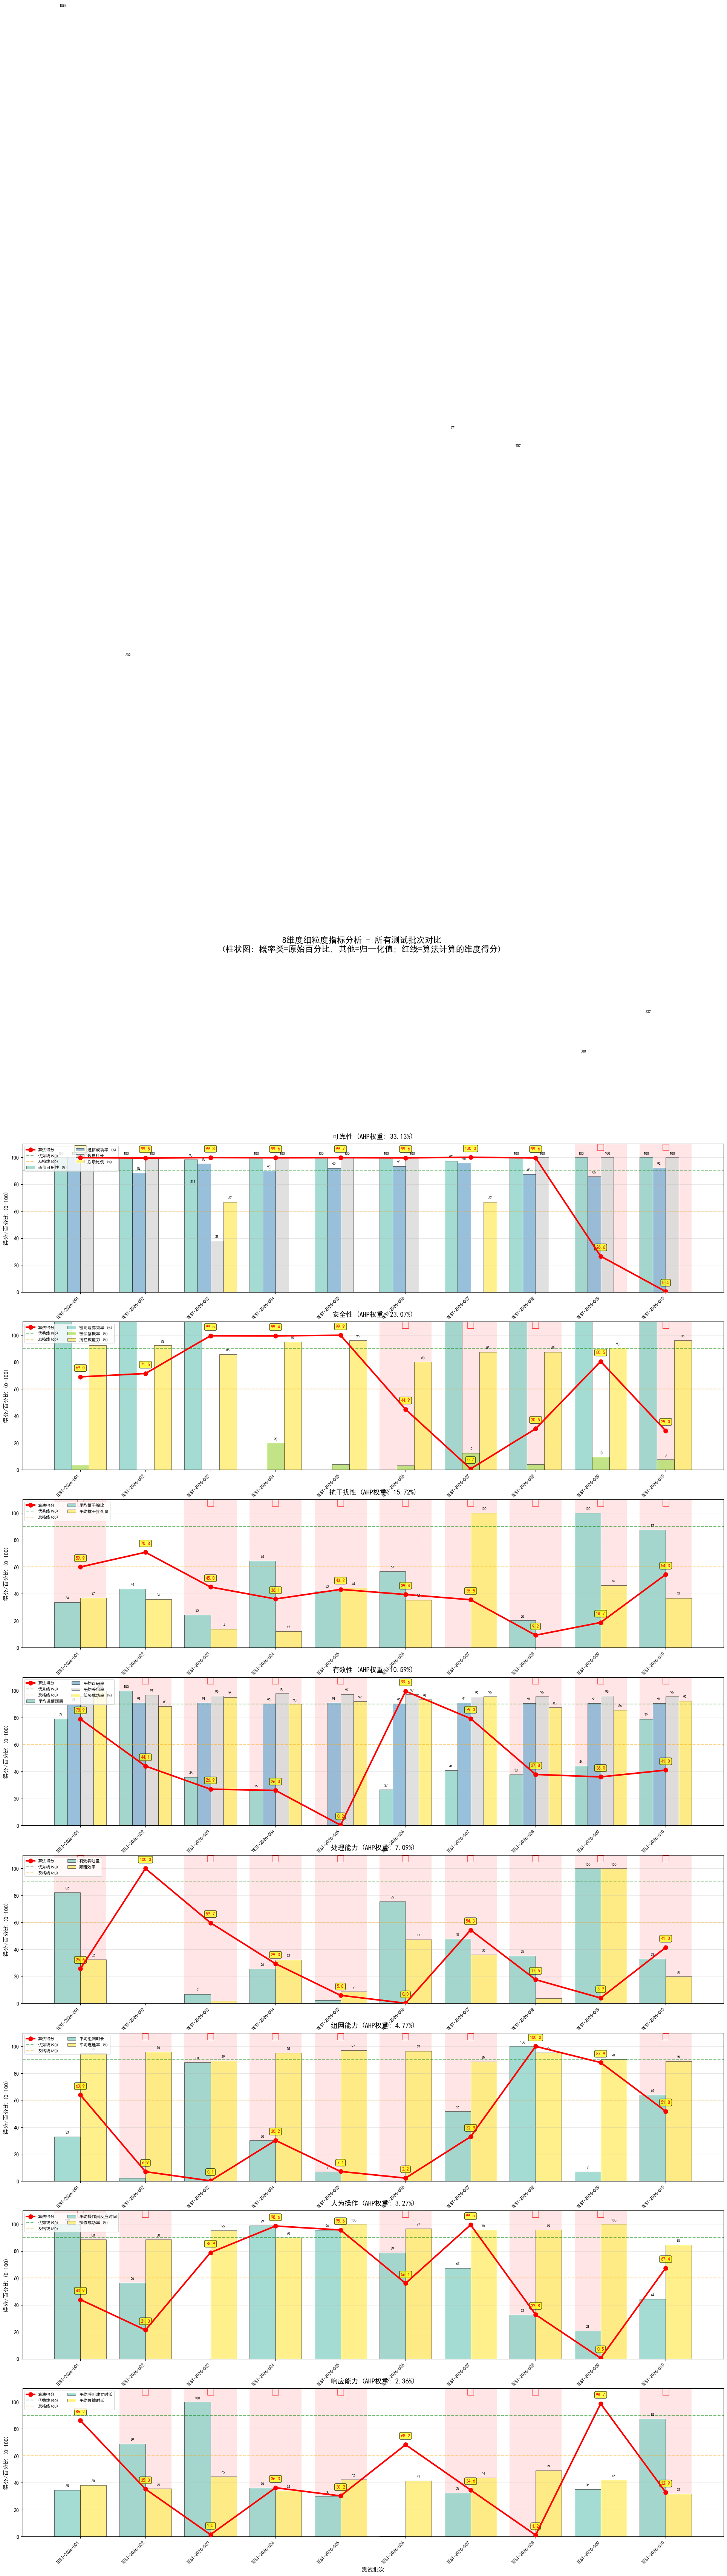


全部评估流程完成！


In [34]:
print("\n" + "="*80)
print("步骤9: 8维度细粒度指标可视化")
print("="*80)
print("绘制8个维度的细粒度指标对比图...")
print("说明: 使用前面计算的AHP权重和算法得分")
print()

from matplotlib.patches import Rectangle

# 创建8个子图（每行一个维度，显示更大）
fig = plt.figure(figsize=(24, 48))

# 创建用于可视化的数据框：概率类指标显示原始值（转为百分比），其他指标显示归一化值
df_visualization = df_raw[['test_id']].copy()

for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        col_name = indicator['code']
        
        if col_name in PROBABILITY_INDICATORS:
            # 概率类指标：显示原始值 × 100（转为百分比）
            df_visualization[col_name] = df_raw[col_name] * 100
        else:
            # 其他指标：显示归一化后的值
            df_visualization[col_name] = df_normalized[col_name]

# 使用前面定义的INDICATOR_SYSTEM和计算的criteria_weights
for idx, dim_code in enumerate(dim_codes_ordered, 1):
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_weight = criteria_weights[idx-1]  # 使用AHP计算的权重
    ax = plt.subplot(8, 1, idx)  # 8行1列，每行一个维度
    
    # 从INDICATOR_SYSTEM获取指标信息
    indicators = [ind['code'] for ind in dim_info['indicators']]
    labels = [ind['name'] for ind in dim_info['indicators']]
    n_indicators = len(indicators)
    n_tests = len(df_visualization)
    
    # 准备数据
    test_ids = df_visualization['test_id'].values
    dim_scores = df_scores[f'{dim_code}_score'].values  # 使用前面计算的维度得分
    
    # 设置柱状图参数
    x = np.arange(n_tests)
    width = 0.8 / n_indicators
    colors = plt.cm.Set3(np.linspace(0, 1, n_indicators))
    
    # 绘制分组柱状图
    for i, (indicator, label) in enumerate(zip(indicators, labels)):
        # 使用可视化数据框的值（概率类为百分比，其他为归一化值）
        values = df_visualization[indicator].values
        offset = (i - n_indicators/2 + 0.5) * width
        
        # 为概率类指标添加标记
        if indicator in PROBABILITY_INDICATORS:
            label_with_mark = f"{label} (%)"
        else:
            label_with_mark = label
        
        bars = ax.bar(x + offset, values, width, label=label_with_mark, 
                     color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 在柱子上标注数值（只标注大于5的值）
        for j, (bar, val) in enumerate(zip(bars, values)):
            if val > 5:
                ax.text(bar.get_x() + bar.get_width()/2, val + 2, 
                       f'{val:.0f}', ha='center', va='bottom', fontsize=7)
    
    # 添加维度得分线（算法计算的得分）
    ax.plot(x, dim_scores, 'r-o', linewidth=3, markersize=8, 
           label=f'算法得分', zorder=10)
    
    # 在得分线上标注分数
    for i, (xi, score) in enumerate(zip(x, dim_scores)):
        ax.text(xi, score + 5, f'{score:.1f}', ha='center', va='bottom',
               fontsize=9, weight='bold', color='red',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 添加参考线
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='优秀线(90)')
    ax.axhline(y=60, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='及格线(60)')
    
    # 设置坐标轴
    ax.set_xlabel('测试批次', fontsize=11, weight='bold')
    ax.set_ylabel('得分/百分比 (0-100)', fontsize=11, weight='bold')
    ax.set_title(f'{dim_info["name"]} (AHP权重: {dim_weight*100:.2f}%)', 
                fontsize=13, weight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(test_ids, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 110)
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    ax.grid(axis='y', alpha=0.3)
    
    # 高亮显示得分异常的测试（低于60分）
    for i, score in enumerate(dim_scores):
        if score < 60:
            # 添加红色背景标记
            rect = Rectangle((x[i]-0.4, 0), 0.8, 110, 
                           facecolor='red', alpha=0.1, zorder=0)
            ax.add_patch(rect)
            ax.text(x[i], 105, '⚠', ha='center', fontsize=16, color='red')

plt.suptitle('8维度细粒度指标分析 - 所有测试批次对比\n(柱状图: 概率类=原始百分比, 其他=归一化值; 红线=算法计算的维度得分)', 
            fontsize=16, weight='bold', y=0.995)
plt.tight_layout()

# 保存图片
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = f'8维度细粒度指标分析_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ 图表已保存: {save_path}")

# 生成详细分析报告
print("\n" + "="*80)
print("【8维度细粒度分析报告】")
print("="*80)

for i, dim_code in enumerate(dim_codes_ordered):
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_weight = criteria_weights[i]  # 使用AHP计算的权重
    
    print(f"\n【{dim_info['name']}】AHP权重: {dim_weight*100:.2f}%")
    print("-"*80)
    
    # 获取该维度的数据
    dim_data = df_scores[['test_id', f'{dim_code}_score']].copy()
    
    # 添加细分指标（概率类显示原始百分比，其他显示归一化值）
    for indicator in dim_info['indicators']:
        code = indicator['code']
        if code in PROBABILITY_INDICATORS:
            # 概率类指标：显示原始值 × 100（百分比）
            dim_data[code] = df_raw[code] * 100
        else:
            # 其他指标：显示归一化值
            dim_data[code] = df_normalized[code]
    
    dim_data = dim_data.sort_values(f'{dim_code}_score', ascending=False)
    
    print("\n排名:")
    for rank, (idx, row) in enumerate(dim_data.iterrows(), 1):
        score = row[f'{dim_code}_score']
        test_id = row['test_id']
        
        if score >= 90:
            grade = "⭐⭐⭐⭐⭐ 优秀"
        elif score >= 80:
            grade = "⭐⭐⭐⭐ 良好"
        elif score >= 70:
            grade = "⭐⭐⭐ 中等"
        elif score >= 60:
            grade = "⭐⭐ 及格"
        else:
            grade = "⚠ 不及格"
        
        print(f"  {rank}. {test_id}: {score:.2f}分 {grade}")
        
        # 显示各指标得分（概率类显示百分比，其他显示归一化值）
        indicator_scores = []
        for indicator in dim_info['indicators']:
            code = indicator['code']
            name = indicator['name']
            val = row[code]
            if code in PROBABILITY_INDICATORS:
                indicator_scores.append(f"{name}={val:.1f}%")
            else:
                indicator_scores.append(f"{name}={val:.1f}")
        print(f"     细分: {', '.join(indicator_scores)}")
    
    # 分析异常值
    print("\n⚠ 需要关注的问题:")
    has_issues = False
    for idx, row in dim_data.iterrows():
        test_id = row['test_id']
        issues = []
        
        for indicator in dim_info['indicators']:
            code = indicator['code']
            name = indicator['name']
            val = row[code]
            if val < 40:
                issues.append(f"{name}过低({val:.1f})")
        
        if issues:
            print(f"  - {test_id}: {', '.join(issues)}")
            has_issues = True
    
    if not has_issues:
        print("  无明显问题 ✓")

print("\n" + "="*80)
print("可视化分析完成！")
print("="*80)
print("\n说明:")
print("  1. 柱状图显示:")
print("     - 概率类指标: 原始百分比值（0-100%），标签带(%)标记")
print("     - 其他指标: 归一化值（0-100分）")
print("  2. 红色折线显示算法计算的维度综合得分")
print("  3. 绿色虚线(90分)表示优秀线，橙色虚线(60分)表示及格线")
print("  4. 红色背景标记表示该测试批次在此维度得分不及格(<60分)")
print("  5. 黄色标签显示算法计算的具体得分，可用于验证算法合理性")
print()
print("💡 验证建议:")
print("  - 概率类指标显示原始百分比，更直观地反映实际性能")
print("  - 检查红线(算法得分)是否与柱状图(指标值)趋势一致")
print("  - 如果某个测试批次所有指标都很高，但算法得分很低，说明权重可能有问题")
print("  - 如果某个测试批次有明显短板(某个指标很低)，算法得分应该受到影响")
print()

plt.show()

print("\n" + "="*80)
print("全部评估流程完成！")
print("="*80)